<a href="https://colab.research.google.com/github/Shakti242/forest-fire/blob/main/forest_fire_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import os
from matplotlib import pyplot as plt
import cv2
from keras.preprocessing import image
from keras.models import load_model
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
!rm -rf /kaggle/working/*

In [3]:
data_dir = '/kaggle/input/forest-fire-dataset/Forest Fire Dataset'

In [9]:
from google.colab import files

# Upload kaggle.json file
files.upload()


Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"shakti2421","key":"d9ee03faeeb9e1d2350e47c4b2036065"}'}

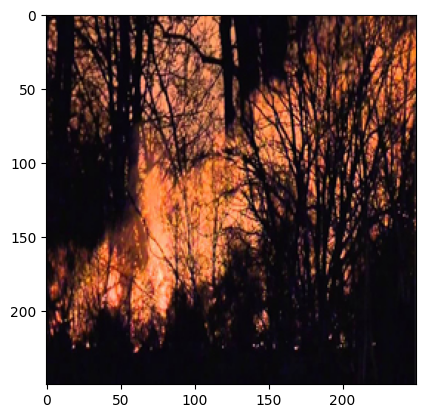

In [16]:
image = cv2.imread(os.path.join('/content/forest-fire-dataset/Forest Fire Dataset/Training/fire/fire_0950.jpg'))
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

In [17]:
Training = tf.keras.utils.image_dataset_from_directory('/content/forest-fire-dataset/Forest Fire Dataset/Training',image_size=(250, 250))
# Testing = tf.keras.utils.image_dataset_from_directory('/content/forest-fire-dataset/Forest Fire Dataset/Testing')

Found 1520 files belonging to 2 classes.


In [18]:
data_iterator = Training.as_numpy_iterator()
# get another batch
batch = data_iterator.next()
batch[1]

array([1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0], dtype=int32)

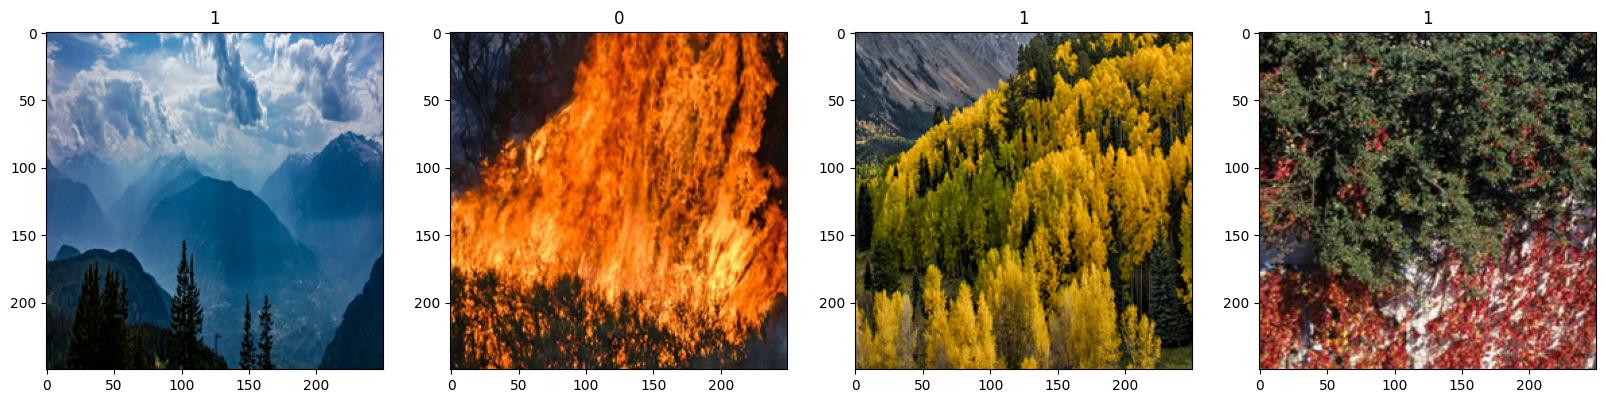

In [19]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

**Fire = 0**

**No Fire = 1**

In [20]:
Training =Training.map(lambda x,y: (x/255, y))

In [21]:
print(Training)

<_MapDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [22]:
train_size = int(len(Training)*.8)
test_size = int(len(Training)*.2)
print("train_size:",train_size,"test_size:",test_size)

train_size: 38 test_size: 9


In [23]:
train = Training.take(train_size)
test = Training.skip(train_size).take(test_size)
print(train,test)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))> <_TakeDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import AdamW

In [25]:
learning_rate = 0.001

model = Sequential()
model.add(Conv2D(250, (3,3),1 , activation='relu', input_shape=(250,250,3)))
model.add(MaxPooling2D())
model.add(Conv2D(125, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(125, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

optimizer = AdamW(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss=tf.losses.binary_crossentropy, metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 248, 248, 250)       │           7,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 124, 124, 250)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 122, 122, 125)       │         281,375 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 61, 61, 125)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 465125)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 125)                 │      58,140,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             126 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,429,251 (222.89 MB)

 Trainable params: 58,429,251 (222.89 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [28]:
hist = model.fit(train, epochs=20, validation_data=test,callbacks=[tensorboard_callback])

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1365s 35s/step - accuracy: 0.6693 - loss: 2.7148 - val_accuracy: 0.9201 - val_loss: 0.2503
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1385s 37s/step - accuracy: 0.9282 - loss: 0.1929 - val_accuracy: 0.9583 - val_loss: 0.1534
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1342s 35s/step - accuracy: 0.9440 - loss: 0.1598 - val_accuracy: 0.9618 - val_loss: 0.1154
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1419s 37s/step - accuracy: 0.9597 - loss: 0.1325 - val_accuracy: 0.9583 - val_loss: 0.1260
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1476s 38s/step - accuracy: 0.9704 - loss: 0.0994 - val_accuracy: 0.9826 - val_loss: 0.0979
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1474s 38s/step - accuracy: 0.9715 - loss: 0.1070 - val_accuracy: 0.9583 - val_loss: 0.1266
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1470s 39s/step - accuracy: 0.9726 - loss: 0.0889 - val_accuracy: 0.9618 - val_loss: 0.1269
Epoch 8/20
17/38 ━━━━━━━━━━━━━━━━━━━━ 12:24 35s/step - accuracy: 0.9901 - loss: 0.0454

KeyboardInterrupt: 

In [29]:
model.save("forest_fire.keras")

In [31]:
model = load_model('/content/forest_fire.keras')

In [32]:
test_folder = '/content/forest-fire-dataset/Forest Fire Dataset/Testing'

In [34]:
import os
import shutil

# Define source directory
source_directory = test_folder

# Define destination directories
fire_directory = '/content/forest-fire-dataset/Forest Fire Dataset/Testing/fire'
nofire_directory = '/content/forest-fire-dataset/Forest Fire Dataset/Testing/no_fire'

# Create fire and nofire directories if they don't exist
os.makedirs(fire_directory, exist_ok=True)
os.makedirs(nofire_directory, exist_ok=True)

# Iterate through files in the source directory
for filename in os.listdir(source_directory):
    source_path = os.path.join(source_directory, filename)
    if filename.startswith('fire_'):
        shutil.copy(source_path, os.path.join(fire_directory, filename))
    elif filename.startswith('nofire_'):
        shutil.copy(source_path, os.path.join(nofire_directory, filename))

print("Images moved successfully.")

Images moved successfully.


In [35]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [36]:
Testing = tf.keras.utils.image_dataset_from_directory('/kaggle/working/Testing',image_size=(250,250))

Found 380 files belonging to 2 classes.


In [37]:
for batch in Testing.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


In [38]:
print(f'Precision:{pre.result()},Recall:{re.result()},Accuracy:{acc.result()}')

Precision:0.9878787994384766,Recall:0.8578947186470032,Accuracy:0.9236842393875122


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


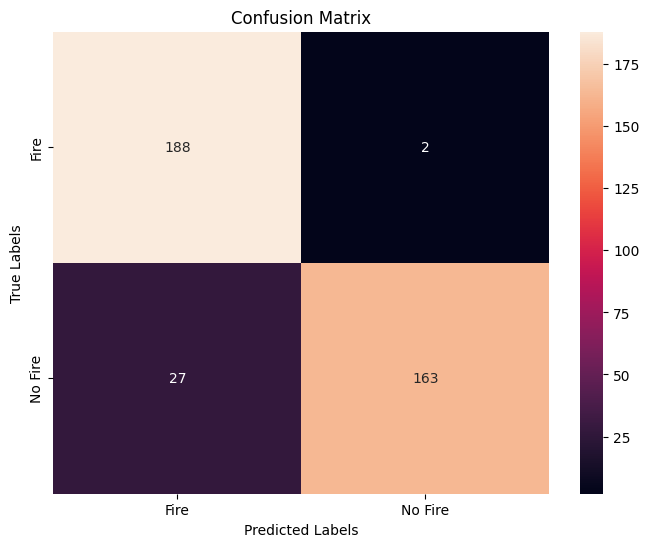

In [39]:
# Initialize the lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation data
for batch in Testing.as_numpy_iterator():
    X, y = batch

    # Predict using the model
    yhat = model.predict(X)

    # Convert predicted probabilities to class labels based on threshold
    y_classes = [1 if pred > 0.5 else 0 for pred in yhat]

    # Update true and predicted labels lists
    true_labels.extend(y)
    predicted_labels.extend(y_classes)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
labels = ['Fire', 'No Fire']
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()